## Overview

This tutorial will differ from the others, in that it can't be run using only checkpoint data but rather requires the original datasets. This is because different subjects have a different number of volumes (or TRs) depending on how long it took them to complete the tasks. Each subject will also have an events.tsv file indicating trial onset times and responses. Thus, this tutorial cannot easily be run online, but we include it here as an illustrative example nonetheless.

section 1) will deal with the Mneumonic Similarity Task (MST). This will involve 1.1) A full walkthrough of one subject analysis, and then looping over subjects, 1.2) Plotting group-level data and significance testing, 1.3) Applying the same to the neocortex instead of hippocampus, and 1.4) Contextualizing resulting hippocampal maps by direct spatial correlation to other HippoMaps features

We will then apply the same steps to 2) an item-pairing task retrieval phase and 3) the same task encoding phase

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
import hippomaps as hm
import pandas as pd
import nilearn
from nilearn.glm.first_level import make_first_level_design_matrix
from nilearn.glm.first_level import run_glm
from nilearn.glm.contrasts import compute_contrast
from brainspace.mesh.mesh_io import read_surface
from brainspace.plotting import plot_hemispheres
from brainspace.datasets import load_group_fc, load_parcellation, load_conte69
from brainspace.utils.parcellation import map_to_labels
import glob

/export03/data/opt/venv/lib/python3.8/site-packages/nilearn/datasets/__init__.py:93: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "
/export03/data/opt/venv/lib/python3.8/site-packages/nilearn/glm/__init__.py:55: FutureWarning: The nilearn.glm module is experimental. It may change in any future release of Nilearn.
  warn('The nilearn.glm module is experimental. '


In [2]:
# locate input data
ses = '01'
micapipe_dir = '/data/mica3/BIDS_MICs/derivatives/micapipe_v0.2.0'
micapipe_raw = '/data/mica3/BIDS_MICs/rawdata/' # this we need for the events.tsv files
hippunfold_dir = '/data/mica3/BIDS_MICs/derivatives/hippunfold_v1.3.0/hippunfold'

# define which subjects and surfaces to examine
subs = [
 'HC001', 'HC002', 'HC005', 'HC006', 'HC007', 'HC011', 'HC012', 'HC013', 'HC014', 'HC015',
 'HC016', 'HC017', 'HC018', 'HC019', 'HC020', 'HC021', 'HC022', 'HC023', 'HC025', 'HC026',
 'HC027', 'HC028', 'HC029', 'HC030', 'HC031', 'HC032', 'HC033', 'HC034', 'HC035', 'HC036', 
 'HC037', 'HC038', 'HC039', 'HC040', 'HC041', 'HC042', 'HC043', 'HC044', 'HC045', 'HC046', 
 'HC047', 'HC048', 'HC049', 'HC050', 'HC051', 'HC052', 'HC053', 'HC054', 'HC055', 'HC056', 
 'HC057', 'HC058', 'HC059', 'HC060', 'HC061', 'HC063', 'HC065', 'HC067', 'HC068', 'HC069', 
 'HC070', 'HC071', 'HC072', 'HC074', 'HC075', 'HC077', 'HC078', 'HC081', 'HC082', 'HC084', 
 'HC086', 'HC087', 'HC088', 'HC089', 'HC090', 'HC093', 'HC097', 'HC100', 'HC024', 'HC064', 
 'HC073', 'HC101']
hemis = ['L','R']
labels = ['hipp']# ,'dentate'] 
den='2mm'
sigma = 1 # Gaussian smoothing kernal sigma (mm) to apply to surface data
TR = 0.6 # repetition time (seconds)
tasks= ['MST2', 'encoding','retrieval']
slice_time_ref = 0.0

# get expected number of vertices and their indices
nV,iV = hm.config.get_nVertices(labels,den) 

# Load neocortical surfaces for visualzation (assets from micapipe)
parcL = nib.load('/data/mica1/01_programs/micapipe-v0.2.0/parcellations/schaefer-400_conte69_lh.label.gii').darrays[0].data
parcR = nib.load('/data/mica1/01_programs/micapipe-v0.2.0/parcellations/schaefer-400_conte69_rh.label.gii').darrays[0].data
nP = len(np.unique(parcL))-1 # number of neocortical parcels (one hemisphere)
iP = [range(nP),range(nP,nP*2)]
parc = np.concatenate((parcL,parcR))
c69_inf_lh= read_surface('/data/mica1/01_programs/micapipe-v0.2.0/surfaces/fsLR-32k.L.inflated.surf.gii', itype='gii')
c69_inf_rh = read_surface('/data/mica1/01_programs/micapipe-v0.2.0/surfaces/fsLR-32k.R.inflated.surf.gii', itype='gii')
labels_c69 = load_parcellation('schaefer', scale=400, join=True)

# 0) Map data to hippocampal surface

In this example, we loop through subjects and hemipsheres, and sample volumetric timeseries data onto hippocampal surfaces. We then apply smoothing. Finally, we save the data from all surfaces into `.func.gii` files.

NOTE: here we save surface fMRI data into a `surf/task-fMRI/` directory within our hippunfold directory. Depending on your lab organization, it may be best to never write project-specific outputs into a shared processed dataset, so consider writing to your own directory instead!

In [ ]:
!mkdir -p tmp
for sub in subs:
    for task in tasks:
        !{f'mkdir -p {hippunfold_dir}/sub-{sub}/ses-{ses}/surf/task-fMRI/{task}'}

        # convert affines 
        cmd1a = f'c3d_affine_tool '\
            f'-itk {micapipe_dir}/sub-{sub}/ses-{ses}/xfm/sub-{sub}_ses-{ses}_from-se_task-{task}_acq-AP_bold_to-nativepro_mode-image_desc-affine_0GenericAffine.mat '\
            f'-o {tmp_dir}/sub-{sub}_ses-{ses}_tmp0GenericAffine0.txt'
        !{cmd1a}
        cmd1b = f'c3d_affine_tool '\
            f'-itk {micapipe_dir}/sub-{sub}/ses-{ses}/xfm/sub-{sub}_ses-{ses}_from-nativepro_func_to-se_task-{task}_acq-AP_bold_mode-image_desc-SyN_0GenericAffine.mat '\
            f'-inv '\
            f'-o {tmp_dir}/sub-{sub}_ses-{ses}_tmp0GenericAffine1.txt'
        !{cmd1b}

        for h,hemi in enumerate(hemis):
            for l,label in enumerate(labels):
                if not glob.glob(f'{hippunfold_dir}/sub-{sub}/ses-{ses}/surf/task-fMRI/{task}/sub-{sub}_ses-{ses}_hemi-{hemi}_space-T1w_den-2mm_label-{label}_{task}_smooth-{sigma}mm.func.gii'):
                    #apply affines
                    cmd2a = f'wb_command -surface-apply-affine '\
                        f'{hippunfold_dir}/sub-{sub}/ses-{ses}/surf/sub-{sub}_ses-{ses}_hemi-{hemi}_space-T1w_den-0p5mm_label-{label}_midthickness.surf.gii '\
                        f'{tmp_dir}/sub-{sub}_ses-{ses}_tmp0GenericAffine0.txt '\
                        f'{tmp_dir}/sub-{sub}_ses-{ses}_{h}_{l}_aff0.surf.gii'
                    !{cmd2a}
                    cmd2b = f'wb_command -surface-apply-affine '\
                        f'{tmp_dir}/sub-{sub}_ses-{ses}_{h}_{l}_aff0.surf.gii '\
                        f'{tmp_dir}/sub-{sub}_ses-{ses}_tmp0GenericAffine1.txt '\
                        f'{tmp_dir}/sub-{sub}_ses-{ses}_{h}_{l}_aff1.surf.gii'
                    !{cmd2b}
                    # apply warp (Note this is actually the INVERSE warp)
                    cmd3 = f'wb_command -surface-apply-warpfield '\
                        f'{tmp_dir}/sub-{sub}_ses-{ses}_{h}_{l}_aff1.surf.gii '\
                        f'{micapipe_dir}/sub-{sub}/ses-{ses}/xfm/sub-{sub}_ses-{ses}_from-nativepro_func_to-se_task-{task}_acq-AP_bold_mode-image_desc-SyN_1Warp.nii.gz '\
                        f'{tmp_dir}/sub-{sub}_ses-{ses}_{h}_{l}_deform.surf.gii'
                    !{cmd3}

                    # sample
                    cmd4 = f'wb_command -volume-to-surface-mapping '\
                        f'{micapipe_dir}/sub-{sub}/ses-{ses}/func/desc-se_task-{task}_acq-AP_bold/volumetric/sub-{sub}_ses-{ses}_space-func_desc-se_preproc.nii.gz '\
                        f'{tmp_dir}/sub-{sub}_ses-{ses}_{h}_{l}_deform.surf.gii '\
                        f'{tmp_dir}/sub-{sub}_ses-{ses}_{h}_{l}_{task}.func.gii '\
                        f'-enclosing'
                    !{cmd4}

                    # smooth
                    cmd5 = f'wb_command -metric-smoothing '\
                        f'{hippunfold_dir}/sub-{sub}/ses-{ses}/surf/sub-{sub}_ses-{ses}_hemi-{hemi}_space-T1w_den-0p5mm_label-{label}_midthickness.surf.gii '\
                        f'{tmp_dir}/sub-{sub}_ses-{ses}_{h}_{l}_{task}.func.gii '\
                        f'{sigma} '\
                        f'{tmp_dir}/sub-{sub}_ses-{ses}_{h}_{l}_{task}_smooth.func.gii '
                    !{cmd5}

                    # downsample
                    func = nib.load(f'{tmp_dir}/sub-{sub}_ses-{ses}_{h}_{l}_{task}_smooth.func.gii')
                    out_array = np.ones((len(func.darrays),nV))
                    for k in range(len(func.darrays)):
                        data, f, v = hm.utils.density_interp('0p5mm', '2mm',func.darrays[k].data, label,'nearest')
                        out_array[k,:] = data
                    data_array = nib.gifti.GiftiDataArray(data=out_array)
                    image = nib.gifti.GiftiImage()
                    image.add_gifti_data_array(data_array)
                    nib.save(image, f'{hippunfold_dir}/sub-{sub}/ses-{ses}/surf/task-fMRI/{task}/sub-{sub}_ses-{ses}_hemi-{hemi}_space-T1w_den-2mm_label-{label}_{task}_smooth-{sigma}mm.func.gii')
!rm -r tmp

# 1.1) GLM fit pattern separation2

First we will walk through how this can be done for one subject, and then we will loop through all subjects

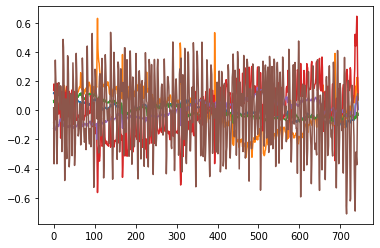

In [3]:
sub = subs[0] # first subject
current_task='MST2'
#list all possible combination of correct answer(target) and subject response 
conditions = ['oldold', 'similarsimilar', 'newnew', 'oldsimilar', 'oldnew', 'similarold', 'similarnew', 'newold', 'newsimilar']

# load in regressors of no interest generated by micapipe
motion_reg = np.loadtxt(f'{micapipe_dir}/sub-{sub}/ses-{ses}/func/desc-se_task-MST2_acq-AP_bold/volumetric/sub-{sub}_ses-{ses}_space-func_desc-se.1D')
# Specify the timing of fmri frames
frame_times = TR * (np.arange(motion_reg.shape[0]) + slice_time_ref)

plt.plot(motion_reg);

    fixation  fixation_dur    onset  duration  keypress  response_time      trial_type
0      2.030         2.826    4.856       2.0     6.445          1.589          oldold
1      6.857         2.718    9.576       2.0    11.357          1.781  similarsimilar
..       ...           ...      ...       ...       ...            ...             ...
94   425.902         2.218  428.120       2.0   429.039          0.919          newnew
95   430.122         3.019  433.141       2.0   434.602          1.461      oldsimilar


/export03/data/opt/venv/lib/python3.8/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `keypress` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/export03/data/opt/venv/lib/python3.8/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/export03/data/opt/venv/lib/python3.8/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `fixation` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/export03/data/opt/venv/lib/python3.8/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `fixation_dur` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "


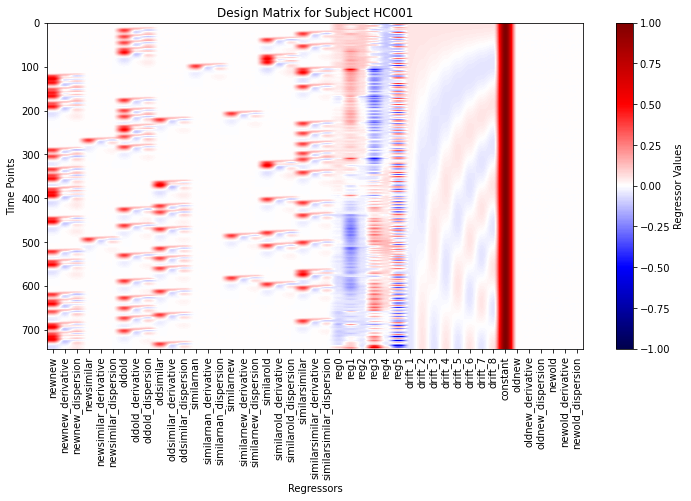

In [4]:
# create design matrix

# Load event files
events = pd.read_table(f'{micapipe_raw}/sub-{sub}/ses-{ses}/func/sub-{sub}_ses-{ses}_task-MST2_events.tsv')
df = events[['event_1_onset','event_1_duration','event_2_onset', 'event_2_duration','event_3_onset','response_time']]
# Recode events to have easy-to-read names
df = df.rename(columns={'event_1_onset': 'fixation', 'event_1_duration': 'fixation_dur','event_2_onset': 'onset', 'event_2_duration': 'duration','event_3_onset': 'keypress'})
# Combine response and condition to get all possible combinations
true_con = events['trial_type'] + events["subject response"].astype('str')
df['trial_type'] = true_con
print(df.to_string(max_rows=4))

design_matrix = make_first_level_design_matrix(frame_times,
                                              events=df,
                                              hrf_model='spm + derivative + dispersion',
                                              add_regs=motion_reg)

# in some cases, there are no trials of a certain type (eg. someone never pressed "new" to and "old" stimulus.
# in this case add extra columns to the design matrix with all 0s
# this will help us look at all trial types later
for condition in conditions:
    if condition not in design_matrix.columns:
        # Create columns for condition, its derivatives, and dispersion
        design_matrix[condition] = 0
        design_matrix[f'{condition}_derivative'] = 0
        design_matrix[f'{condition}_dispersion'] = 0    
        
# plot design matrix
plt.figure(figsize=(12, 6))
plt.imshow(design_matrix.values, aspect='auto', cmap='seismic', vmin=-1, vmax=1)
plt.title(f'Design Matrix for Subject {sub}')
plt.xticks(range(len(design_matrix.columns)), design_matrix.columns, rotation=90)
plt.xlabel('Regressors')
plt.ylabel('Time Points')
plt.colorbar(label='Regressor Values')
plt.show()

In [5]:
# define contrasts of interest
# nibabel expects contrasts to be defined as a dictionary. Here, we first make a dictionary of basic contrasts for each column of our design matrix (1 for that column, 0 for all others)

contrast_matrix = np.eye(design_matrix.shape[1])
basic_contrasts = dict([(column, contrast_matrix[i])
            for i, column in enumerate(design_matrix.columns)])

# now we define actual contrasts of interest for each trial type, without subtracting any other trial type (i.e. uncorrected)
contrasts = {
'patternseparation_uncorrected': (
    basic_contrasts['similarsimilar']
    + basic_contrasts['similarsimilar_derivative']
    + basic_contrasts['similarsimilar_dispersion']),
'patterncompletion_uncorrected': (
    basic_contrasts['oldsimilar']
    + basic_contrasts['oldsimilar_derivative']
    + basic_contrasts['oldsimilar_dispersion']),
'noveltydetection_uncorrected': (
    basic_contrasts['newnew']
    + basic_contrasts['newnew_derivative']
    + basic_contrasts['newnew_dispersion']),
# now we will subtract trials where the subject "failed" the trial type of interest
'patternseparation': (
    basic_contrasts['similarsimilar']
    - basic_contrasts['similarnew']
    + basic_contrasts['similarsimilar_derivative']
    - basic_contrasts['similarnew_derivative']
    + basic_contrasts['similarsimilar_dispersion']
    - basic_contrasts['similarnew_dispersion']),
'patterncompletion': (
    basic_contrasts['oldsimilar']
    - basic_contrasts['oldnew']
    + basic_contrasts['oldsimilar_derivative']
    - basic_contrasts['oldnew_derivative']
    + basic_contrasts['oldsimilar_dispersion']
    - basic_contrasts['oldnew_dispersion']),
'noveltydetection': (
    basic_contrasts['newnew']
    - 0.5*basic_contrasts['oldsimilar']
    - 0.5*basic_contrasts['oldnew']
    + basic_contrasts['newnew_derivative']
    - 0.5*basic_contrasts['oldsimilar_derivative']
    - 0.5*basic_contrasts['oldnew_derivative']
    + basic_contrasts['newnew_dispersion']
    - 0.5*basic_contrasts['oldsimilar_dispersion']
    - 0.5*basic_contrasts['oldnew_dispersion'])}

contrasts

{'patternseparation_uncorrected': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 'patterncompletion_uncorrected': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 'noveltydetection_uncorrected': array([1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 'patternseparation': array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0., -1., -1., -1.,  0.,  0.,  0.,  1.,  1.,  1.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.]),
 'pa

Now we'll fit the actual data to the design matrix and run our contrasts of interest!

In [ ]:
# Load the neocortical timeseries and parcellate to schaefer 400 space
fmri_img_neo = nib.load(f'{micapipe_dir}/sub-{sub}/ses-{ses}/func/desc-se_task-MST2_acq-AP_bold/surf/sub-{sub}_ses-{ses}_surf-fsLR-32k_desc-timeseries_clean.shape.gii').darrays[0].data
neo_ts_parc = np.ones((fmri_img_neo.shape[0], nP*2))
for i in range(nP*2):
    neo_ts_parc[:, i] = np.nanmean(fmri_img_neo[:, parc == (i + 1)], axis=1)

# fit the design matrix to the data
labels_, estimates = run_glm(neo_ts_parc, design_matrix.values)

# run contrasts of interest
for index, (contrast_id, contrast_val) in enumerate(contrasts.items()):
    # Compute contrast-related statistics
    contrast = compute_contrast(labels_, estimates, contrast_val,
                                contrast_type='t')
    # We present the Z-transform of the t map
    z_score = contrast.z_score()

    #create and save gifti images 
    for h,hemi in enumerate(hemis):
        gii = nib.gifti.GiftiImage()
        gii.add_gifti_data_array(nib.gifti.GiftiDataArray(data=z_score[iP[h]]))
        nib.save(gii, f'{hippunfold_dir}/sub-{sub}/ses-{ses}/surf/task-fMRI/{current_task}/sub-{sub}_hemi-{hemi}_space-T1w_den-2mm_label-schaefer-400_task-{current_task}_contrast-{contrast_id}.shape.gii')

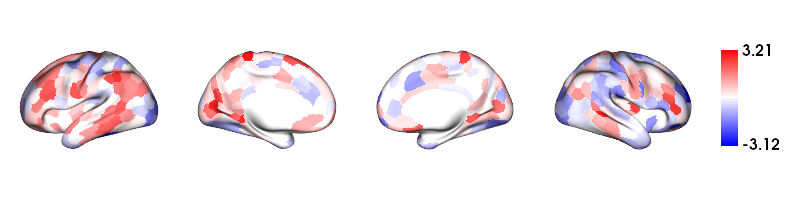

In [69]:
# plot neocortical results (from the last iteration above. That is - noveltydetection for the right hemisphere)
mc = np.ones([c69_inf_lh.n_points + c69_inf_rh.n_points])*np.nan
for h,hemi in enumerate(hemis):
    for i in range(nP):
        mc[parc==(i+1+(h*nP))] = z_score[iP[h]][i]
plot_hemispheres( c69_inf_lh,  c69_inf_rh,array_name=np.hsplit(mc,1), 
                 size=(800,200), color_bar=True, cmap='bwr', embed_nb=True,nan_color=(1, 1, 1, 1))

In [ ]:
# same as above, but for hippocampus

for h, hemi in enumerate(hemis):
    for l,label in enumerate(labels):
        cdata_hipp = nib.load(f'{hippunfold_dir}/sub-{sub}/ses-{ses}/surf/task-fMRI/MST2/sub-{sub}_ses-{ses}_hemi-{hemi}_space-T1w_den-2mm_label-hipp_MST2_smooth-1mm.func.gii').darrays[0].data
        
        # fit the design matrix to the data
        labels_, estimates = run_glm(cdata_hipp, design_matrix.values)
        
        # run contrasts of interest
        for index, (contrast_id, contrast_val) in enumerate(contrasts.items()):
            # Compute contrast-related statistics
            contrast = compute_contrast(labels_, estimates, contrast_val,
                                        contrast_type='t')
            # We present the Z-transform of the t map
            z_score = contrast.z_score()

            #create and save gifti images 
            for h,hemi in enumerate(hemis):
                gii = nib.gifti.GiftiImage()
                gii.add_gifti_data_array(nib.gifti.GiftiDataArray(data=z_score[iP[h]]))
                nib.save(gii, f'{hippunfold_dir}/sub-{sub}/ses-{ses}/surf/task-fMRI/{current_task}/sub-{sub}_hemi-{hemi}_space-T1w_den-2mm_label-{label}_task-{current_task}_contrast-{contrast_id}.shape.gii')

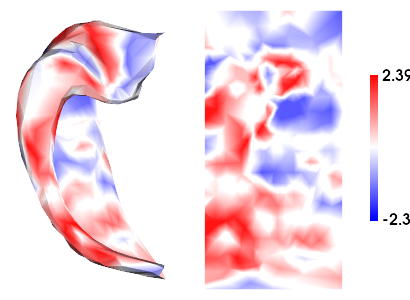

In [73]:
# plot hippocampal results (from the last iteration above. That is - noveltydetection for the right hemisphere)
hm.plotting.surfplot_canonical_foldunfold(z_score, den='2mm', hemis=['L'], labels=labels, tighten_cwindow=True, unfoldAPrescale=True, cmap='bwr', color_range='sym', share='row', color_bar='right', embed_nb=True)

## Now that we've run through a full example for one subject, we'll loop through all subjects and save the data:

In [ ]:
#list all possible combination of correct answer(target) and subject response 
conditions = ['oldold', 'similarsimilar', 'newnew', 'oldsimilar', 'oldnew', 'similarold', 'similarnew', 'newold', 'newsimilar']
current_task='MST2'
for sub in subs: 
    
    # load in regressors of no interest generated by micapipe
    motion_reg = np.loadtxt(f'{micapipe_dir}/sub-{sub}/ses-{ses}/func/desc-se_task-MST2_acq-AP_bold/volumetric/sub-{sub}_ses-{ses}_space-func_desc-se.1D')
    # Specify the timing of fmri frames
    frame_times = TR * (np.arange(motion_reg.shape[0]) + slice_time_ref)

    ### create design matrix ###

    # Load event files
    events = pd.read_table(f'{micapipe_raw}/sub-{sub}/ses-{ses}/func/sub-{sub}_ses-{ses}_task-MST2_events.tsv')
    df = events[['event_1_onset','event_1_duration','event_2_onset', 'event_2_duration','event_3_onset','response_time']]
    # Recode events to have easy-to-read names
    df.rename(columns={'event_1_onset': 'fixation', 'event_1_duration': 'fixation_dur','event_2_onset': 'onset', 'event_2_duration': 'duration','event_3_onset': 'keypress'}, inplace=True)
    # Combine response and condition to get all possible combinations
    true_con = events['trial_type'] + events["subject response"].astype('str')
    df['trial_type'] = true_con

    design_matrix = make_first_level_design_matrix(frame_times,
                                                  events=df,
                                                  hrf_model='spm + derivative + dispersion',
                                                  add_regs=motion_reg)

    # in some cases, there are no trials of a certain type (eg. someone never pressed "new" to and "old" stimulus.
    # in this case add extra columns to the design matrix with all 0s
    # this will help us look at all trial types later
    for condition in conditions:
        if condition not in design_matrix.columns:
            # Create columns for condition, its derivatives, and dispersion
            design_matrix[condition] = 0
            design_matrix[f'{condition}_derivative'] = 0
            design_matrix[f'{condition}_dispersion'] = 0  

    ### define contrasts of interest ###

    contrast_matrix = np.eye(design_matrix.shape[1])
    basic_contrasts = dict([(column, contrast_matrix[i])
                for i, column in enumerate(design_matrix.columns)])

    # now we define actual contrasts of interest for each trial type, without subtracting any other trial type (i.e. uncorrected)
    contrasts = {
    'patternseparation_uncorrected': (
        basic_contrasts['similarsimilar']
        + basic_contrasts['similarsimilar_derivative']
        + basic_contrasts['similarsimilar_dispersion']),
    'patterncompletion_uncorrected': (
        basic_contrasts['oldsimilar']
        + basic_contrasts['oldsimilar_derivative']
        + basic_contrasts['oldsimilar_dispersion']),
    'noveltydetection_uncorrected': (
        basic_contrasts['newnew']
        + basic_contrasts['newnew_derivative']
        + basic_contrasts['newnew_dispersion']),
    # now we will subtract trials where the subject "failed" the trial type of interest
    'patternseparation': (
        basic_contrasts['similarsimilar']
        - basic_contrasts['similarnew']
        + basic_contrasts['similarsimilar_derivative']
        - basic_contrasts['similarnew_derivative']
        + basic_contrasts['similarsimilar_dispersion']
        - basic_contrasts['similarnew_dispersion']),
    'patterncompletion': (
        basic_contrasts['oldsimilar']
        - basic_contrasts['oldnew']
        + basic_contrasts['oldsimilar_derivative']
        - basic_contrasts['oldnew_derivative']
        + basic_contrasts['oldsimilar_dispersion']
        - basic_contrasts['oldnew_dispersion']),
    'noveltydetection': (
        basic_contrasts['newnew']
        - 0.5*basic_contrasts['oldsimilar']
        - 0.5*basic_contrasts['oldnew']
        + basic_contrasts['newnew_derivative']
        - 0.5*basic_contrasts['oldsimilar_derivative']
        - 0.5*basic_contrasts['oldnew_derivative']
        + basic_contrasts['newnew_dispersion']
        - 0.5*basic_contrasts['oldsimilar_dispersion']
        - 0.5*basic_contrasts['oldnew_dispersion'])}
    
    ### fit the data ###

    # Load the neocortical timeseries and parcellate to schaefer 400 space
    fmri_img_neo = nib.load(f'{micapipe_dir}/sub-{sub}/ses-{ses}/func/desc-se_task-MST2_acq-AP_bold/surf/sub-{sub}_ses-{ses}_surf-fsLR-32k_desc-timeseries_clean.shape.gii').darrays[0].data
    neo_ts_parc = np.ones((fmri_img_neo.shape[0], nP*2))
    for i in range(nP*2):
        neo_ts_parc[:, i] = np.nanmean(fmri_img_neo[:, parc == (i + 1)], axis=1)

    labels_, estimates = run_glm(neo_ts_parc, design_matrix.values)

    # run contrasts of interest
    for index, (contrast_id, contrast_val) in enumerate(contrasts.items()):
        # Compute contrast-related statistics
        contrast = compute_contrast(labels_, estimates, contrast_val,
                                    contrast_type='t')
        # We present the Z-transform of the t map
        z_score = contrast.z_score()

        #create and save gifti images 
        for h,hemi in enumerate(hemis):
            gii = nib.gifti.GiftiImage()
            gii.add_gifti_data_array(nib.gifti.GiftiDataArray(data=z_score[iP[h]]))
            nib.save(gii, f'{hippunfold_dir}/sub-{sub}/ses-{ses}/surf/task-fMRI/{current_task}/sub-{sub}_hemi-{hemi}_space-T1w_den-2mm_label-schaefer-400_task-{current_task}_contrast-{contrast_id}.shape.gii')

    # same as above, but for hippocampus

    for h, hemi in enumerate(hemis):
        for l,label in enumerate(labels):
            cdata_hipp = nib.load(f'{hippunfold_dir}/sub-{sub}/ses-{ses}/surf/task-fMRI/MST2/sub-{sub}_ses-{ses}_hemi-{hemi}_space-T1w_den-2mm_label-hipp_MST2_smooth-1mm.func.gii').darrays[0].data

            # fit the design matrix to the data
            labels_, estimates = run_glm(cdata_hipp, design_matrix.values)

            # run contrasts of interest
            for index, (contrast_id, contrast_val) in enumerate(contrasts.items()):
                # Compute contrast-related statistics
                contrast = compute_contrast(labels_, estimates, contrast_val,
                                            contrast_type='t')
                # We present the Z-transform of the t map
                z_score = contrast.z_score()

                #create and save gifti images 
                for h,hemi in enumerate(hemis):
                    gii = nib.gifti.GiftiImage()
                    gii.add_gifti_data_array(nib.gifti.GiftiDataArray(data=z_score[iP[h]]))
                    nib.save(gii, f'{hippunfold_dir}/sub-{sub}/ses-{ses}/surf/task-fMRI/{current_task}/sub-{sub}_hemi-{hemi}_space-T1w_den-2mm_label-{label}_task-{current_task}_contrast-{contrast_id}.shape.gii')

# 1.2) Group-averaging and significance/consistency testing

In [6]:
#compute average across subjects for each contrasts and plot hippocampal findings 
contrastnames_patternsep2=list(contrasts.keys())
contrasts_patternsep2 = np.ones((nV, len(hemis), len(subs), len(contrastnames_patternsep2))) * np.nan
for s, sub in enumerate(subs):
    for h, hemi in enumerate(hemis):
        for l, label in enumerate(labels):
            for c, contrast_name in enumerate(contrastnames_patternsep2):                 
                contrast_file = f'{hippunfold_dir}/sub-{sub}/ses-{ses}/surf/task-fMRI/MST2/sub-{sub}_hemi-{hemi}_space-T1w_den-2mm_label-{label}_task-MST2_contrast-{contrast_name}.shape.gii'
                contrasts_patternsep2[iV[l], h, s, c] = nib.load(contrast_file).darrays[0].data

/export03/data/opt/venv/lib/python3.8/site-packages/brainspace/plotting/base.py:287: UserWarning: Interactive mode requires 'panel'. Setting 'interactive=False'
  warnings.warn("Interactive mode requires 'panel'. "


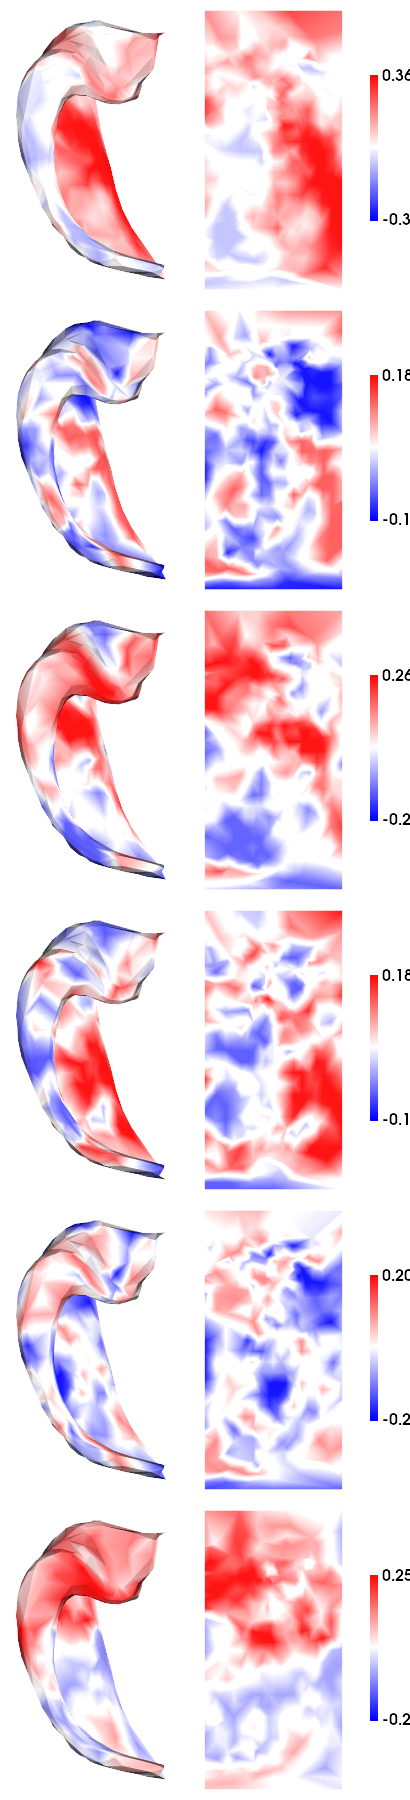

In [7]:
hm.plotting.surfplot_canonical_foldunfold(np.nanmean(contrasts_patternsep2,axis=(1,2)), den='2mm', hemis=['L'], labels=labels, tighten_cwindow=True, unfoldAPrescale=True, cmap='bwr', color_range='sym', share='row', color_bar='right', embed_nb=True)

## significance testing

We won't go into detail here, but this gives a basic idea of (uncorrected) significance values. Ideally, some cluster correction should be applied

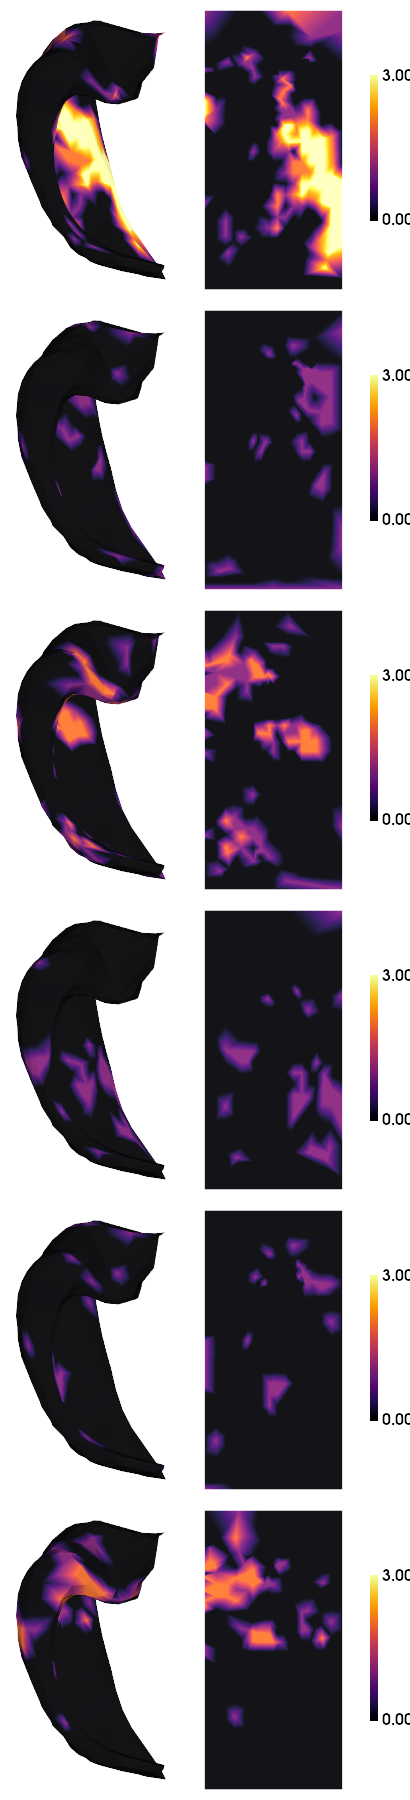

In [78]:
from scipy.stats import ttest_1samp
t = ttest_1samp(contrasts_patternsep2.reshape(nV,2*len(subs),len(contrastnames_patternsep2)),0,axis=1)
tmap = np.zeros(t[1].shape)
tmap[t[1]<(0.05)] = 1
tmap[t[1]<(0.01)] = 2
tmap[t[1]<(0.001)] = 3
hm.plotting.surfplot_canonical_foldunfold(tmap, den='2mm', labels=labels, hemis=['L'], tighten_cwindow=True, unfoldAPrescale=True, cmap='inferno', share='row', color_range=(0,3), color_bar='right', embed_nb=True)

## Additional consistency checks

Rather than significance, we can also check consistency between subject results

Ttest_1sampResult(statistic=8.131151229499595, pvalue=6.04322441312396e-16)
Ttest_1sampResult(statistic=1.363577810547197, pvalue=0.17281415626269864)
Ttest_1sampResult(statistic=7.303670529693287, pvalue=3.4889664571640743e-13)
Ttest_1sampResult(statistic=1.8870055398040273, pvalue=0.0592467512150204)
Ttest_1sampResult(statistic=0.5960190493982473, pvalue=0.5512041478784316)
Ttest_1sampResult(statistic=3.080369254500647, pvalue=0.0020843689241653303)
Ttest_1sampResult(statistic=6.742503182407484, pvalue=1.8436025081957323e-11)
Ttest_1sampResult(statistic=1.3213936432198694, pvalue=0.18648210464974158)
Ttest_1sampResult(statistic=4.48349257894886, pvalue=7.591531266935211e-06)
Ttest_1sampResult(statistic=1.2144603328144792, pvalue=0.22465836124383068)
Ttest_1sampResult(statistic=0.000554492664403062, pvalue=0.9995576131626948)
Ttest_1sampResult(statistic=2.880721728081016, pvalue=0.003993087634010751)


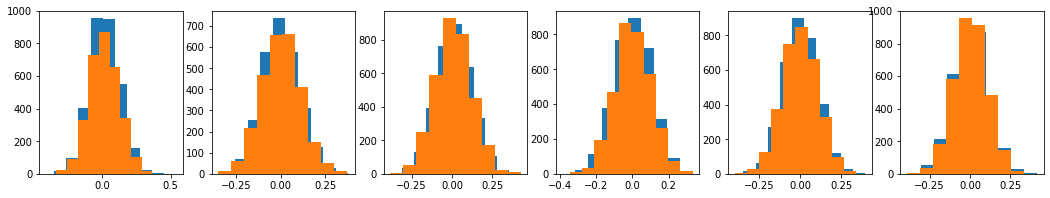

In [82]:
mfcorr = []
sdfcorr = []
corr = np.zeros((len(subs),len(subs),2,len(contrastnames_patternsep2)))
fig, ax = plt.subplots(nrows=1, ncols=len(contrastnames_patternsep2), figsize=(3*len(contrastnames_patternsep2),3))
for h,hemi in enumerate(hemis):
    for f,feature in enumerate(contrastnames_patternsep2):
        cdat = contrasts_patternsep2[:,h,:,f].reshape((nV,-1))
        corr[:,:,h,f] = np.corrcoef(cdat.T)
        fcorr = corr[:,:,h,f][np.triu_indices(len(subs),k=1)]
        print(ttest_1samp(fcorr,0,nan_policy='omit'))
        ax[f].hist(fcorr)
        mfcorr.append(np.nanmean(fcorr))
        sdfcorr.append(np.nanstd(fcorr))

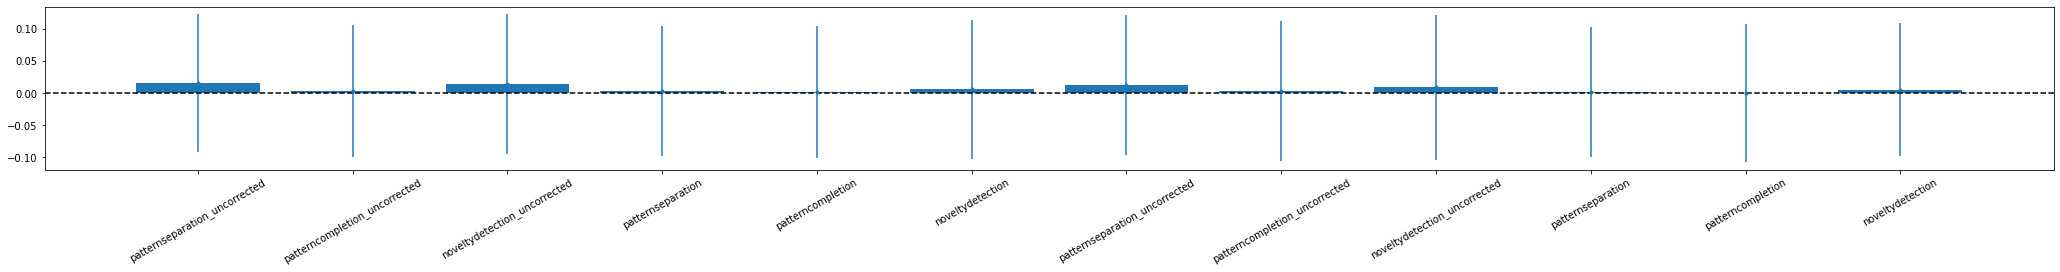

In [138]:
xnames = contrastnames_patternsep2 + contrastnames_patternsep2

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(3*len(xnames),3))
plt.bar(range(len(xnames)),mfcorr)
plt.errorbar(range(len(xnames)),mfcorr, yerr=sdfcorr, fmt=".")
plt.xticks(ticks=range(len(xnames)),labels=xnames,rotation=30);
plt.axhline(y=0, color='k', linestyle='--')

In [ ]:
#save the average maps
for h,hemi in enumerate(hemis):
    for l,label in enumerate(labels): 
        for cname in contrastnames_patternsep2:
            contrast_idx = cname.index(cname)
            cdat = np.nanmean(contrasts_patternsep2[iV[l],h,:,contrast_idx],axis=1).flatten()
            data_array = nib.gifti.GiftiDataArray(data=cdat)
            image = nib.gifti.GiftiImage()
            image.add_gifti_data_array(data_array)
            nib.save(image, f'../maps/HippoMaps-initializationMaps/Dataset-MICs/MRI-3T-MST2_average-{len(subs)}_hemi-{hemi}_den-2mm_label-{label}_contrast-{cname}.shape.gii')

## 1.3) Consider neocortical results

All the same as above, but with neocortical surfaces (and stacking left+right hemispheres)

In [97]:
contrasts_patternsep2_neo = np.ones((nP, len(hemis), len(subs), len(contrastnames_patternsep2))) * np.nan

for s, sub in enumerate(subs):
    for h, hemi in enumerate(hemis):
        for c, contrast_name in enumerate(contrastnames_patternsep2): 
            contrast_file = f'{hippunfold_dir}/sub-{sub}/ses-{ses}/surf/task-fMRI/MST2/sub-{sub}_hemi-{hemi}_space-T1w_den-2mm_label-schaefer-400_task-MST2_contrast-{contrast_name}.shape.gii'
            contrasts_patternsep2_neo[:,h, s, c] = nib.load(contrast_file).darrays[0].data

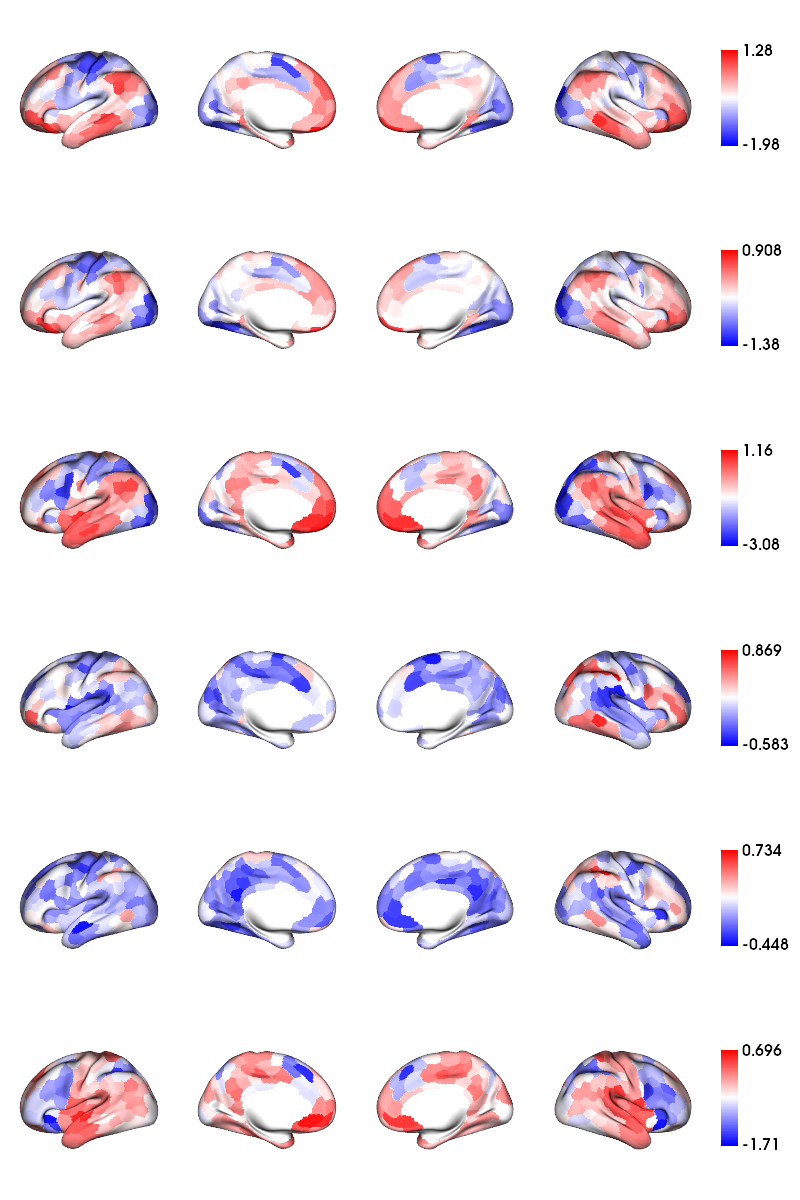

In [116]:
mc = np.ones([c69_inf_lh.n_points + c69_inf_rh.n_points, len(contrastnames_patternsep2)])*np.nan
for h,hemi in enumerate(hemis):
    for i in range(nP):
        for c, contrast_name in enumerate(contrastnames_patternsep2): 
            mc[parc==(i+1+(h*nP)),c] = np.nanmean(contrasts_patternsep2_neo,axis=2)[i,h,c]
            
plot_hemispheres(c69_inf_lh, c69_inf_rh,array_name=np.hsplit(mc,len(contrastnames_patternsep2)), 
                 size=(800,200*len(contrastnames_patternsep2)), color_bar=True, cmap='bwr', embed_nb=True,nan_color=(1, 1, 1, 1))

Ttest_1sampResult(statistic=125.44587709572133, pvalue=0.0)
Ttest_1sampResult(statistic=74.74538598254394, pvalue=0.0)
Ttest_1sampResult(statistic=159.3452219200208, pvalue=0.0)
Ttest_1sampResult(statistic=31.226919970854308, pvalue=1.1110902175829445e-206)
Ttest_1sampResult(statistic=13.57098750722382, pvalue=1.1414292911457831e-41)
Ttest_1sampResult(statistic=61.59369873800046, pvalue=0.0)


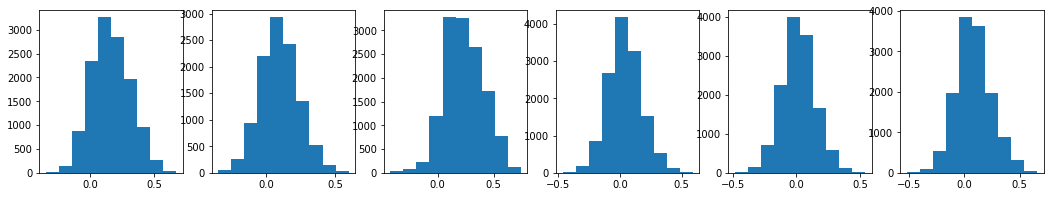

In [117]:
mfcorr = []
sdfcorr = []
corr = np.zeros((len(subs)*2,len(subs)*2,len(contrastnames_patternsep2)))
fig, ax = plt.subplots(nrows=1, ncols=len(contrastnames_patternsep2), figsize=(3*len(contrastnames_patternsep2),3))
for f,feature in enumerate(contrastnames_patternsep2):
    cdat = contrasts_patternsep2_neo[:,:,:,f].reshape((nP,-1))
    corr[:,:,f] = np.corrcoef(cdat.T)
    fcorr = corr[:,:,f][np.triu_indices(len(subs)*2,k=1)]
    print(ttest_1samp(fcorr,0,nan_policy='omit'))
    ax[f].hist(fcorr)
    mfcorr.append(np.nanmean(fcorr))
    sdfcorr.append(np.nanstd(fcorr))

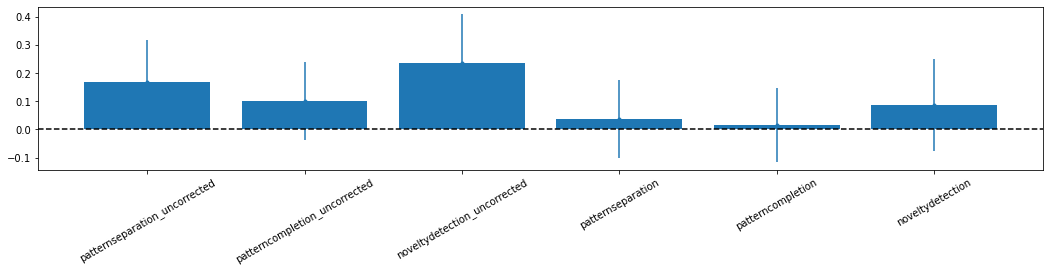

In [118]:
xnames = contrastnames_patternsep2

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(3*len(contrastnames_patternsep2),3))
plt.bar(range(len(contrastnames_patternsep2)),mfcorr)
plt.errorbar(range(len(contrastnames_patternsep2)),mfcorr, yerr=sdfcorr, fmt=".")
plt.xticks(ticks=range(len(contrastnames_patternsep2)),labels=xnames,rotation=30);
plt.axhline(y=0, color='k', linestyle='--')
#plt.ylim([0,.9]);

## 1.4) Compare to previously mapped features

In HippoMaps, we present a high-order space of all features correlated with a continuous anterior-posterior axis by a discrete proximal-distal subfields. Here, we reload that space to find where the present maps fall, and which other mapped features they are most similar to

/export03/data/opt/venv/lib/python3.8/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/export03/data/opt/venv/lib/python3.8/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


[['histology-thickness' 'MRI-3T-rsfMRI-avgFCneocort'
  'histology-curvature']
 ['iEEG-BandPower-beta' 'iEEG-BandPower-gamma' 'iEEG-BandPower-theta']]
[[ 0.65634844  0.60399173 -0.56773163]
 [-0.6378841  -0.5906666   0.54140302]]
[[0.    0.    0.   ]
 [0.    0.001 0.004]]


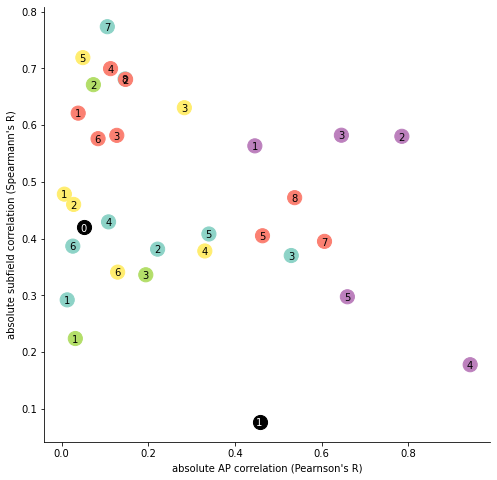

In [8]:
# here we look only at the pattern separation and novelty conditions
feats_to_examine = [0,2]
cdata = np.nanmean(contrasts_patternsep2,axis=(1,2))[:,feats_to_examine]
topFeatures, topR, topP, APcorr, Subfscorr, ax = hm.stats.contextualize2D(cdata, nperm=1000) # ideally nperm should be 10000

print(topFeatures)
print(topR)
print(topP)

# 2.1) GLM fit for episodic retrieval

This section is very similar to the above, but with different input data, conditions, and contrasts. We also don't walk through one subject, but rather run all subjects together

In [93]:
conditions = ['remembered', 'forgotten']
current_task='retrieval'
for sub in subs:
    # Specify the timing of fmri frames from one example
    motion_reg=np.loadtxt(f'{micapipe_dir}/sub-{sub}/ses-{ses}/func/desc-se_task-retrieval_acq-AP_bold/volumetric/sub-{sub}_ses-{ses}_space-func_desc-se.1D')
    frame_times = TR * (np.arange(motion_reg.shape[0]) + slice_time_ref)

    ### create design matrix ###
    
    # Load event files
    events_file = f'{micapipe_raw}/sub-{sub}/ses-{ses}/func/sub-{sub}_ses-{ses}_task-retrieval_events.tsv'
    events = pd.read_table(events_file)
    df = events[['event_1_onset','event_1_duration','event_2_onset', 'event_2_duration','event_3_onset','response_time','subject_response','prime','target']]
    # Recode events to have easy-to-read names
    df.rename(columns={'event_1_onset': 'fixation', 'event_1_duration': 'fixation_dur','event_2_onset': 'onset', 'event_2_duration': 'duration','event_3_onset': 'keypress'}, inplace=True)
    df['trial_type']=None
    df['trial_type'] = df.apply(lambda row: 'remembered' if row['target'] == row['subject_response'] else 'forgotten', axis=1)

    design_matrix = make_first_level_design_matrix(frame_times,
                                                  events=df,
                                                  hrf_model='spm + derivative + dispersion',
                                                  add_regs=motion_reg
                                                  )
    # in case of some trial types missing, add extras with all 0sL
    for condition in conditions:
        if condition not in design_matrix.columns:
            # Create columns for condition, its derivatives, and dispersion
            design_matrix[condition] = 0
            design_matrix[f'{condition}_derivative'] = 0
            design_matrix[f'{condition}_dispersion'] = 0    
            
            
    ### define contrasts of interest ###

    contrast_matrix = np.eye(design_matrix.shape[1])
    basic_contrasts = dict([(column, contrast_matrix[i])
                for i, column in enumerate(design_matrix.columns)])

    contrasts = {
    'retrieval_uncorrected': (
        basic_contrasts['remembered']
        + basic_contrasts['remembered_derivative']
        + basic_contrasts['remembered_dispersion']),
    'retrieval_corrected': (
        basic_contrasts['remembered']
        - basic_contrasts['forgotten']
        + basic_contrasts['remembered_derivative']
        - basic_contrasts['forgotten_derivative']
        + basic_contrasts['remembered_dispersion']
        + basic_contrasts['forgotten_dispersion'])}
    
    
    ### fit the data ###

    # Load the neocortical timeseries and parcellate to schaefer 400 space
    fmri_img_neo = nib.load(f'{micapipe_dir}/sub-{sub}/ses-{ses}/func/desc-se_task-MST2_acq-AP_bold/surf/sub-{sub}_ses-{ses}_surf-fsLR-32k_desc-timeseries_clean.shape.gii').darrays[0].data
    neo_ts_parc = np.ones((fmri_img_neo.shape[0], nP*2))
    for i in range(nP*2):
        neo_ts_parc[:, i] = np.nanmean(fmri_img_neo[:, parc == (i + 1)], axis=1)

    labels_, estimates = run_glm(neo_ts_parc, design_matrix.values)

    # run contrasts of interest
    for index, (contrast_id, contrast_val) in enumerate(contrasts.items()):
        # Compute contrast-related statistics
        contrast = compute_contrast(labels_, estimates, contrast_val,
                                    contrast_type='t')
        # We present the Z-transform of the t map
        z_score = contrast.z_score()

        #create and save gifti images 
        for h,hemi in enumerate(hemis):
            gii = nib.gifti.GiftiImage()
            gii.add_gifti_data_array(nib.gifti.GiftiDataArray(data=z_score[iP[h]]))
            nib.save(gii, f'{hippunfold_dir}/sub-{sub}/ses-{ses}/surf/task-fMRI/{current_task}/sub-{sub}_hemi-{hemi}_space-T1w_den-2mm_label-schaefer-400_task-{current_task}_contrast-{contrast_id}.shape.gii')

    # same as above, but for hippocampus

    for h, hemi in enumerate(hemis):
        for l,label in enumerate(labels):
            cdata_hipp = nib.load(f'{hippunfold_dir}/sub-{sub}/ses-{ses}/surf/task-fMRI/MST2/sub-{sub}_ses-{ses}_hemi-{hemi}_space-T1w_den-2mm_label-hipp_MST2_smooth-1mm.func.gii').darrays[0].data

            # fit the design matrix to the data
            labels_, estimates = run_glm(cdata_hipp, design_matrix.values)

            # run contrasts of interest
            for index, (contrast_id, contrast_val) in enumerate(contrasts.items()):
                # Compute contrast-related statistics
                contrast = compute_contrast(labels_, estimates, contrast_val,
                                            contrast_type='t')
                # We present the Z-transform of the t map
                z_score = contrast.z_score()

                #create and save gifti images 
                for h,hemi in enumerate(hemis):
                    gii = nib.gifti.GiftiImage()
                    gii.add_gifti_data_array(nib.gifti.GiftiDataArray(data=z_score[iP[h]]))
                    nib.save(gii, f'{hippunfold_dir}/sub-{sub}/ses-{ses}/surf/task-fMRI/{current_task}/sub-{sub}_hemi-{hemi}_space-T1w_den-2mm_label-{label}_task-{current_task}_contrast-{contrast_id}.shape.gii')

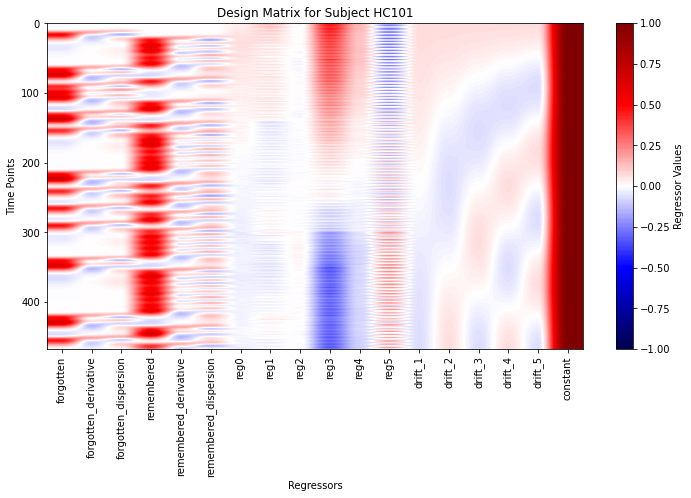

In [94]:
# plot design matrix of the last subject
plt.figure(figsize=(12, 6))
plt.imshow(design_matrix.values, aspect='auto', cmap='seismic', vmin=-1, vmax=1)
plt.title(f'Design Matrix for Subject {sub}')
plt.xticks(range(len(design_matrix.columns)), design_matrix.columns, rotation=90)
plt.xlabel('Regressors')
plt.ylabel('Time Points')
plt.colorbar(label='Regressor Values')
plt.show()

# 2.2) Group-averaging and significance/consistency testing

In [96]:
#compute average across subjects for each contrasts and plot hippocampal findings 
contrastnames_epiretrieve=list(contrasts.keys())
contrasts_retrieval = np.ones((nV, 2, len(subs), len(contrastnames_epiretrieve))) * np.nan
for s, sub in enumerate(subs):
    for h, hemi in enumerate(hemis):
        for l, label in enumerate(labels):
            for c, contrast_name in enumerate(contrastnames_epiretrieve):
                contrast_file = f'{hippunfold_dir}/sub-{sub}/ses-{ses}/surf/task-fMRI/retrieval/sub-{sub}_hemi-{hemi}_space-T1w_den-2mm_label-{label}_task-retrieval_contrast-{contrast_name}.shape.gii'
                contrasts_retrieval[ind[l], h, s, c] = nib.load(contrast_file).darrays[0].data

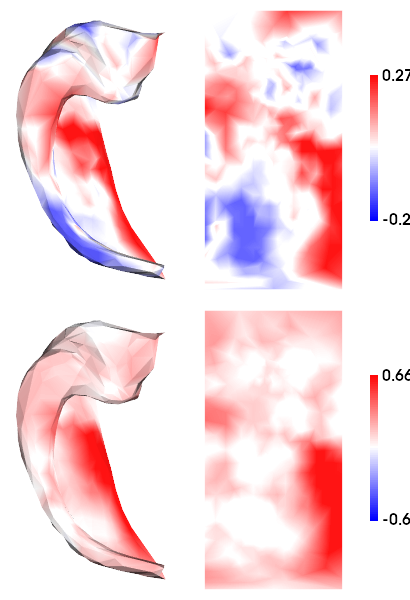

In [247]:
hm.plotting.surfplot_canonical_foldunfold(np.nanmean(contrasts_retrieval,axis=(1,2)), den='2mm', hemis=['L'], labels=labels, tighten_cwindow=True, cmap='bwr', color_range='sym', unfoldAPrescale=True,  share='row', color_bar='right', embed_nb=True)

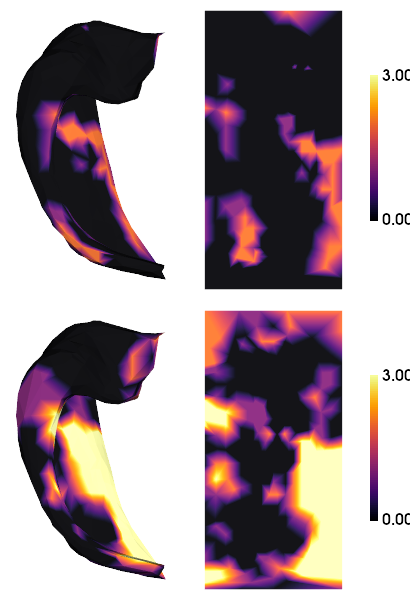

In [256]:
from scipy.stats import ttest_1samp
t = ttest_1samp(contrasts_retrieval.reshape((nV,2*len(subs),len(contrastnames_epiretrieve))),0,axis=1)
tmap = np.zeros(t[1].shape)
tmap[t[1]<(0.05)] = 1
tmap[t[1]<(0.01)] = 2
tmap[t[1]<(0.001)] = 3
hm.plotting.surfplot_canonical_foldunfold(tmap, den='2mm', labels=labels, hemis=['L'], tighten_cwindow=True, unfoldAPrescale=True, cmap='inferno', share='row', color_range=(0,3), color_bar='right', embed_nb=True)

In [ ]:
#save the average maps
# Select the corrected contrasts only 
selected_contrastnames = contrastnames_epiretrieve[-1:]
for h,hemi in enumerate(hemis):
    for l,label in enumerate(labels): 
        for contrastname_epiretrieve in selected_contrastnames:
            contrast_idx = contrastnames_epiretrieve.index(contrastname_epiretrieve)
            cdat = np.nanmean(contrasts_retrieval[ind[l],h,:,contrast_idx],axis=1).flatten()
            data_array = nib.gifti.GiftiDataArray(data=cdat)
            image = nib.gifti.GiftiImage()
            image.add_gifti_data_array(data_array)
            nib.save(image, f'../maps/HippoMaps-initializationMaps/Dataset-MICs/MRI-3T-epiretrieve_average-{len(subs)}_hemi-{hemi}_den-2mm_label-{label}_contrast-{contrastname_epiretrieve}.shape.gii')

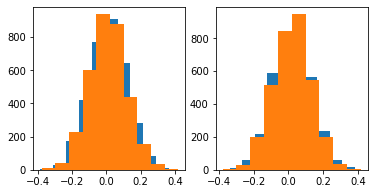

In [139]:
mfcorr = []
sdfcorr = []
corr = np.zeros((len(subs),len(subs),2,len(contrastnames_epiretrieve)))
fig, ax = plt.subplots(nrows=1, ncols=len(contrastnames_epiretrieve), figsize=(3*len(contrastnames_epiretrieve),3))
for h,hemi in enumerate(hemis):
    for f,feature in enumerate(contrastnames_epiretrieve):
        cdat = contrasts_retrieval[:,h,:,f].reshape((nV,-1))
        corr[:,:,h,f] = np.corrcoef(cdat.T)
        fcorr = corr[:,:,h,f][np.triu_indices(len(subs),k=1)]
        print(ttest_1samp(fcorr,0,nan_policy='omit'))
        ax[f].hist(fcorr)
        mfcorr.append(np.nanmean(fcorr))
        sdfcorr.append(np.nanstd(fcorr))

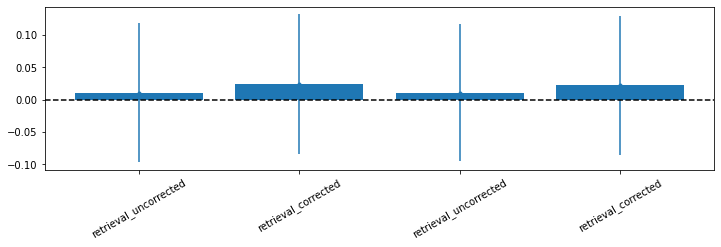

In [140]:
xnames = contrastnames_epiretrieve + contrastnames_epiretrieve

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(3*len(xnames),3))
plt.bar(range(len(xnames)),mfcorr)
plt.errorbar(range(len(xnames)),mfcorr, yerr=sdfcorr, fmt=".")
plt.xticks(ticks=range(len(xnames)),labels=xnames,rotation=30);
plt.axhline(y=0, color='k', linestyle='--')
#plt.ylim([0,.9]);

## 2.3) Consider the neocortex

In [39]:
#compute average across subjects for each contrasts and plot neocortical findings 
contrasts_retrieval_neo = np.ones((nP, len(hemis), len(subs), len(contrastnames_epiretrieve))) * np.nan

for s, sub in enumerate(subs):
    for h, hemi in enumerate(hemis):
        for c, contrast_name in enumerate(contrastnames_epiretrieve): 
            contrast_file = f'{hippunfold_dir}/sub-{sub}/ses-{ses}/surf/task-fMRI/retrieval/sub-{sub}_hemi-{hemi}_space-T1w_den-2mm_label-schaefer-400_task-retrieval_contrast-{contrast_name}.shape.gii'
            contrasts_retrieval_neo[:,h, s, c] = nib.load(contrast_file).darrays[0].data

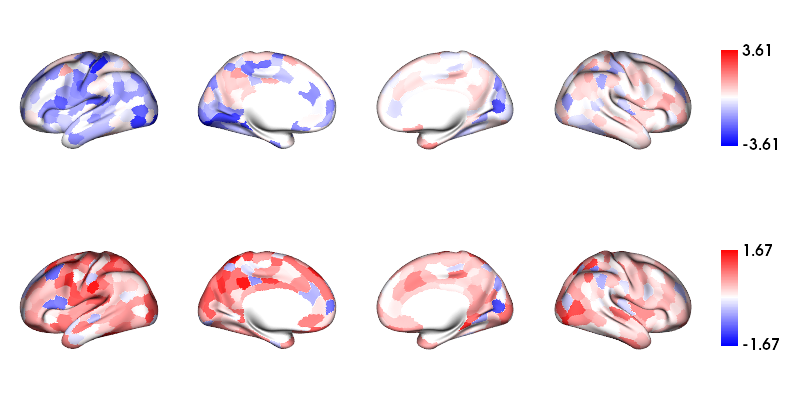

In [226]:
mc = np.ones([c69_inf_lh.n_points + c69_inf_rh.n_points, len(contrastnames_epiretrieve)])*np.nan
for h,hemi in enumerate(hemis):
    for i in range(nP):
        for c, contrast_name in enumerate(contrastnames_epiretrieve): 
            mc[parc==(i+1+(h*nP))] = np.nanmean(contrasts_retrieval_neo,axis=2)[i,h,c]
plot_hemispheres( c69_inf_lh,  c69_inf_rh,array_name=np.hsplit(mc,len(contrastnames_epiretrieve)), 
                 size=(800,200*len(contrastnames_epiretrieve)), color_bar=True, cmap='bwr', embed_nb=True,nan_color=(1, 1, 1, 1))

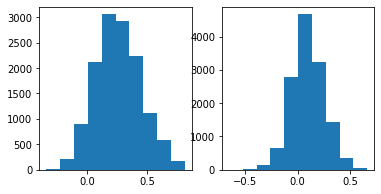

In [101]:
mfcorr = []
sdfcorr = []
corr = np.zeros((len(subs)*2,len(subs)*2,len(contrastnames_epiretrieve)))
fig, ax = plt.subplots(nrows=1, ncols=len(contrastnames_epiretrieve), figsize=(3*len(contrastnames_epiretrieve),3))
for f,feature in enumerate(contrastnames_epiretrieve):
    cdat = contrasts_retrieval_neo[:,:,:,f].reshape((nP,-1))
    corr[:,:,f] = np.corrcoef(cdat.T)
    fcorr = corr[:,:,f][np.triu_indices(len(subs)*2,k=1)]
    ax[f].hist(fcorr)
    mfcorr.append(np.nanmean(fcorr))
    sdfcorr.append(np.nanstd(fcorr))

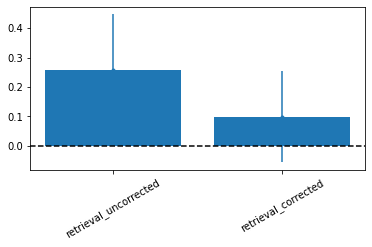

In [102]:
xnames = contrastnames_epiretrieve

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(3*len(contrastnames_epiretrieve),3))
plt.bar(range(len(contrastnames_epiretrieve)),mfcorr)
plt.errorbar(range(len(contrastnames_epiretrieve)),mfcorr, yerr=sdfcorr, fmt=".")
plt.xticks(ticks=range(len(contrastnames_epiretrieve)),labels=xnames,rotation=30);
plt.axhline(y=0, color='k', linestyle='--')
#plt.ylim([0,.9]);

# 3.1) GLM fit for episodic encoding -subsequent memory 

Again, this section is very similar to the above, but with different input data, conditions, and contrasts. We also don't walk through one subject, but rather run all subjects together

In [104]:
conditions = ['correct', 'incorrect']
current_task='encoding'
for sub in subs[-1:]:
    # Specify the timing of fmri frames from one example
    motion_reg=np.loadtxt(f'{micapipe_dir}/sub-{sub}/ses-{ses}/func/desc-se_task-encoding_acq-AP_bold/volumetric/sub-{sub}_ses-{ses}_space-func_desc-se.1D')
    frame_times = TR * (np.arange(motion_reg.shape[0]) + slice_time_ref)

    ### create design matrix ###
    
    # This is slightly more complicated now since we need to look up which stimuli were actually subsequently remmebered by matching their IDs
    
    # Load encoding file
    encoding_file = f'{micapipe_raw}/sub-{sub}/ses-{ses}/func/sub-{sub}_ses-{ses}_task-encoding_events.tsv'
    df_encode = pd.read_table(encoding_file)
    df_encode= df_encode[['event_1_onset','event_1_duration','event_2_onset', 'stim_duration','stim_1','stim_2']]
    # Recode events to have easy-to-read names
    df_encode.rename(columns={'event_1_onset': 'fixation', 'event_1_duration': 'fixation_dur','event_2_onset': 'onset', 'stim_duration': 'duration'}, inplace=True)
    # Load retrieval file
    retrieval_file = f'{micapipe_raw}/sub-{sub}/ses-{ses}/func/sub-{sub}_ses-{ses}_task-retrieval_events.tsv'
    df_retrieve = pd.read_table(retrieval_file)
    df_retrieve=df_retrieve[['event_1_onset', 'event_1_duration', 'event_2_onset', 'event_2_duration', 'prime', 'target', 'event_3_onset','subject_response']]
    # Recode events to have easy-to-read names
    df_retrieve.rename(columns={'event_1_onset': 'fixation', 'event_1_duration': 'fixation_dur', 'event_2_onset': 'onset', 'event_2_duration': 'duration', 'event_3_onset': 'keypress'}, inplace=True)
    df_retrieve['trial_type']=None
    df_retrieve['trial_type'] = df_retrieve.apply(lambda row: 'correct' if row['target'] == row['subject_response'] else 'incorrect', axis=1)

    new_df = pd.DataFrame(columns=['onset','duration','prime','target','trial_type'])
    # Dictionary to keep track of matched rows in df_retrieve
    matched_rows_dict = {}

    # Iterate through rows in encoding data
    i=0
    for index, row_encode in df_encode.iterrows():
        stim_1 = row_encode['stim_1']
        stim_2 = row_encode['stim_2']

        # Check if this pair has already been matched
        if (stim_1, stim_2) not in matched_rows_dict:
            # Match rows in retrieval data based on stim_1 and stim_2
            match_rows = df_retrieve[(df_retrieve['prime'] == stim_1) & (df_retrieve['target'] == stim_2)]

            # If there is exactly one match, append the data to the design matrix
            if len(match_rows) == 1:
                matched_row = match_rows.iloc[0]
                new_df.loc[i] = [row_encode['onset'],
                                 row_encode['duration'],
                                 matched_row['prime'],
                                 matched_row['target'],
                                 matched_row['trial_type']]
                i+=1

                # Update the matched_rows_dict to mark this pair as matched
                matched_rows_dict[(stim_1, stim_2)] = True
            else:
                # If there is no match or multiple matches, mark this pair as unmatched
                matched_rows_dict[(stim_1, stim_2)] = False

    design_matrix = make_first_level_design_matrix(frame_times,
                                      events=new_df,
                                      hrf_model='spm + derivative + dispersion',
                                      add_regs=motion_reg)
    for condition in conditions:
        if condition not in design_matrix.columns:
            design_matrix[condition] = 0
            design_matrix[f'{condition}_derivative'] = 0
            design_matrix[f'{condition}_dispersion'] = 0
            
    ### define contrasts of interest ###

    contrast_matrix = np.eye(design_matrix.shape[1])
    basic_contrasts = dict([(column, contrast_matrix[i])
                for i, column in enumerate(design_matrix.columns)])

    contrasts = {
                    'subsequent_memory_uncorrected': (
                        basic_contrasts['correct']
                        + basic_contrasts['correct_derivative']
                        + basic_contrasts['correct_dispersion']),
                    'subsequent_memory_corrected': (
                        basic_contrasts['correct']
                        - basic_contrasts['incorrect']
                        + basic_contrasts['correct_derivative']
                        - basic_contrasts['incorrect_derivative']
                        + basic_contrasts['correct_dispersion']
                        - basic_contrasts['incorrect_dispersion'])}           

    ### fit the data ###

    # Load the neocortical timeseries and parcellate to schaefer 400 space
    fmri_img_neo = nib.load(f'{micapipe_dir}/sub-{sub}/ses-{ses}/func/desc-se_task-MST2_acq-AP_bold/surf/sub-{sub}_ses-{ses}_surf-fsLR-32k_desc-timeseries_clean.shape.gii').darrays[0].data
    neo_ts_parc = np.ones((fmri_img_neo.shape[0], nP*2))
    for i in range(nP*2):
        neo_ts_parc[:, i] = np.nanmean(fmri_img_neo[:, parc == (i + 1)], axis=1)

    labels_, estimates = run_glm(neo_ts_parc, design_matrix.values)

    # run contrasts of interest
    for index, (contrast_id, contrast_val) in enumerate(contrasts.items()):
        # Compute contrast-related statistics
        contrast = compute_contrast(labels_, estimates, contrast_val,
                                    contrast_type='t')
        # We present the Z-transform of the t map
        z_score = contrast.z_score()

        #create and save gifti images 
        for h,hemi in enumerate(hemis):
            gii = nib.gifti.GiftiImage()
            gii.add_gifti_data_array(nib.gifti.GiftiDataArray(data=z_score[iP[h]]))
            nib.save(gii, f'{hippunfold_dir}/sub-{sub}/ses-{ses}/surf/task-fMRI/{current_task}/sub-{sub}_hemi-{hemi}_space-T1w_den-2mm_label-schaefer-400_task-{current_task}_contrast-{contrast_id}.shape.gii')

    # same as above, but for hippocampus

    for h, hemi in enumerate(hemis):
        for l,label in enumerate(labels):
            cdata_hipp = nib.load(f'{hippunfold_dir}/sub-{sub}/ses-{ses}/surf/task-fMRI/MST2/sub-{sub}_ses-{ses}_hemi-{hemi}_space-T1w_den-2mm_label-hipp_MST2_smooth-1mm.func.gii').darrays[0].data

            # fit the design matrix to the data
            labels_, estimates = run_glm(cdata_hipp, design_matrix.values)

            # run contrasts of interest
            for index, (contrast_id, contrast_val) in enumerate(contrasts.items()):
                # Compute contrast-related statistics
                contrast = compute_contrast(labels_, estimates, contrast_val,
                                            contrast_type='t')
                # We present the Z-transform of the t map
                z_score = contrast.z_score()

                #create and save gifti images 
                for h,hemi in enumerate(hemis):
                    gii = nib.gifti.GiftiImage()
                    gii.add_gifti_data_array(nib.gifti.GiftiDataArray(data=z_score[iP[h]]))
                    nib.save(gii, f'{hippunfold_dir}/sub-{sub}/ses-{ses}/surf/task-fMRI/{current_task}/sub-{sub}_hemi-{hemi}_space-T1w_den-2mm_label-{label}_task-{current_task}_contrast-{contrast_id}.shape.gii')

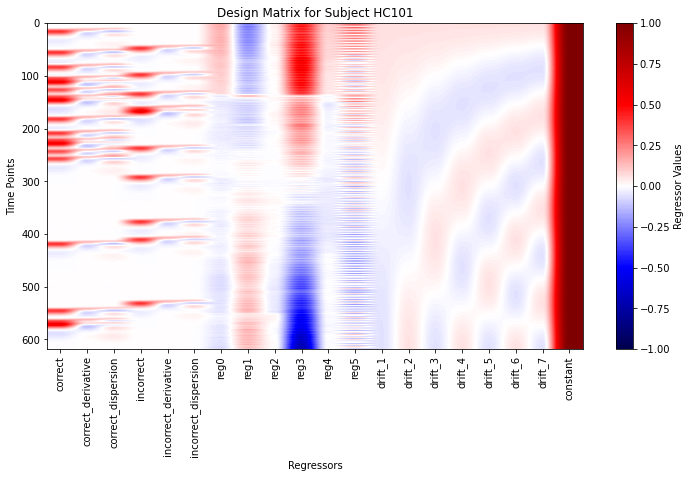

In [105]:
# plot design matrix of the last subject
plt.figure(figsize=(12, 6))
plt.imshow(design_matrix.values, aspect='auto', cmap='seismic', vmin=-1, vmax=1)
plt.title(f'Design Matrix for Subject {sub}')
plt.xticks(range(len(design_matrix.columns)), design_matrix.columns, rotation=90)
plt.xlabel('Regressors')
plt.ylabel('Time Points')
plt.colorbar(label='Regressor Values')
plt.show()

# 3.2) Group-averaging and significance/consistency testing

In [107]:
#compute average across subjects for each contrasts and plot hippocampal findings 
contrastnames_epiencode=list(contrasts.keys())
contrasts_epiencode = np.ones((nV, 2, len(subs), len(contrastnames_epiencode))) * np.nan
for s, sub in enumerate(subs):
    for h, hemi in enumerate(hemis):
        for l, label in enumerate(labels):
            for c, contrastname_epiencode in enumerate(contrastnames_epiencode):
                contrast_file = f'{hippunfold_dir}/sub-{sub}/ses-{ses}/surf/task-fMRI/encoding/sub-{sub}_hemi-{hemi}_space-T1w_den-2mm_label-{label}_task-encoding_contrast-{contrastname_epiencode}.shape.gii'
                contrasts_epiencode[ind[l], h, s, c] = nib.load(contrast_file).darrays[0].data

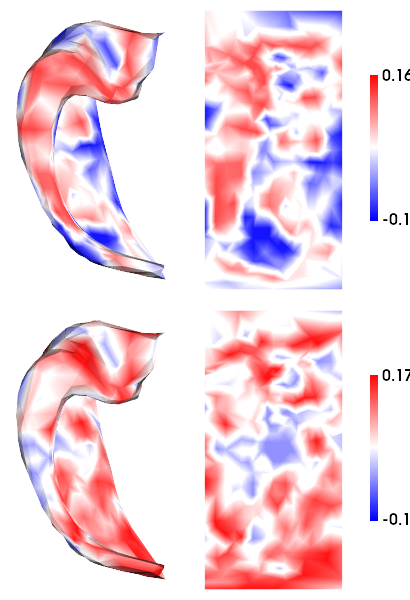

In [249]:
hm.plotting.surfplot_canonical_foldunfold(np.nanmean(contrasts_epiencode,axis=(1,2)), den='2mm', hemis=['L'], labels=labels, tighten_cwindow=True, cmap='bwr', color_range='sym', unfoldAPrescale=True,  share='row', color_bar='right', embed_nb=True)

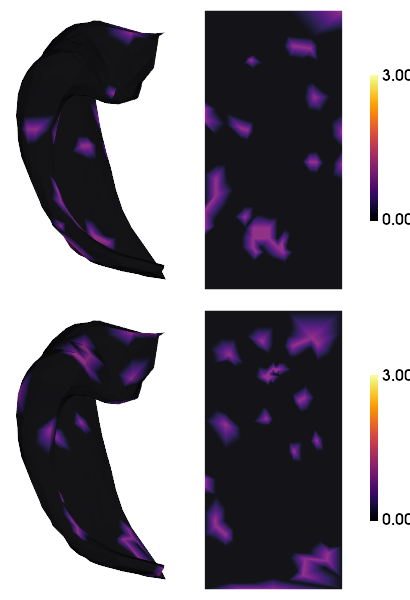

In [257]:
from scipy.stats import ttest_1samp
t = ttest_1samp(contrasts_epiencode.reshape((nV,2*len(subs),len(contrastnames_epiencode))),0,axis=1)
tmap = np.zeros(t[1].shape)
tmap[t[1]<(0.05)] = 1
tmap[t[1]<(0.01)] = 2
tmap[t[1]<(0.001)] = 3
hm.plotting.surfplot_canonical_foldunfold(tmap, den='2mm', labels=labels, hemis=['L'], tighten_cwindow=True, unfoldAPrescale=True, cmap='inferno', share='row', color_range=(0,3), color_bar='right', embed_nb=True)

In [111]:
#save the average maps
# Select the corrected contrasts only 
selected_contrastnames = contrastnames_epiencode[-1:]
for h,hemi in enumerate(hemis):
    for l,label in enumerate(labels): 
        for contrastname_epiencode in selected_contrastnames:
            contrast_idx = contrastnames_epiencode.index(contrastname_epiencode)
            cdat = np.nanmean(contrasts_epiencode[ind[l],h,:,contrast_idx],axis=1).flatten()
            data_array = nib.gifti.GiftiDataArray(data=cdat)
            image = nib.gifti.GiftiImage()
            image.add_gifti_data_array(data_array)
            nib.save(image, f'../maps/HippoMaps-initializationMaps/Dataset-MICs/MRI-3T-epiencode_average-{len(subs)}-{hemi}_den-2mm_label-{label}_contrast-{contrastname_epiencode}.shape.gii')

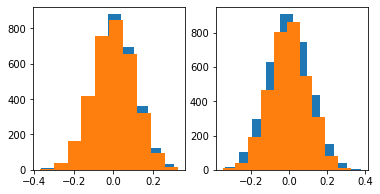

In [142]:
mfcorr = []
sdfcorr = []
corr = np.zeros((len(subs),len(subs),2,len(contrastnames_epiencode)))
fig, ax = plt.subplots(nrows=1, ncols=len(contrastnames_epiencode), figsize=(3*len(contrastnames_epiencode),3))
for h,hemi in enumerate(hemis):
    for f,feature in enumerate(contrastnames_epiencode):
        cdat = contrasts_epiencode[:,h,:,f].reshape((nV,-1))
        corr[:,:,h,f] = np.corrcoef(cdat.T)
        fcorr = corr[:,:,h,f][np.triu_indices(len(subs),k=1)]
        ax[f].hist(fcorr)
        mfcorr.append(np.nanmean(fcorr))
        sdfcorr.append(np.nanstd(fcorr))

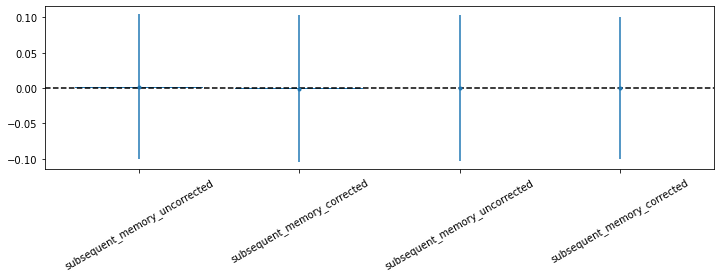

In [143]:
xnames = contrastnames_epiencode + contrastnames_epiencode

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(3*len(xnames),3))
plt.bar(range(len(xnames)),mfcorr)
plt.errorbar(range(len(xnames)),mfcorr, yerr=sdfcorr, fmt=".")
plt.xticks(ticks=range(len(xnames)),labels=xnames,rotation=30);
plt.axhline(y=0, color='k', linestyle='--')
#plt.ylim([0,.9]);

## 3.3) Consider the neocortex

In [114]:
#compute average across subjects for each contrasts and plot neocortical findings 
contrasts_epiencode_neo = np.ones((nP, len(hemis), len(subs), len(contrastnames_epiencode))) * np.nan

for s, sub in enumerate(subs):
    for h, hemi in enumerate(hemis):
        for c, contrast_name in enumerate(contrastnames_epiencode): 
            contrast_file = f'{hippunfold_dir}/sub-{sub}/ses-{ses}/surf/task-fMRI/encoding/sub-{sub}_hemi-{hemi}_space-T1w_den-2mm_label-schaefer-400_task-encoding_contrast-{contrast_name}.shape.gii'
            contrasts_epiencode_neo[:,h, s, c] = nib.load(contrast_file).darrays[0].data

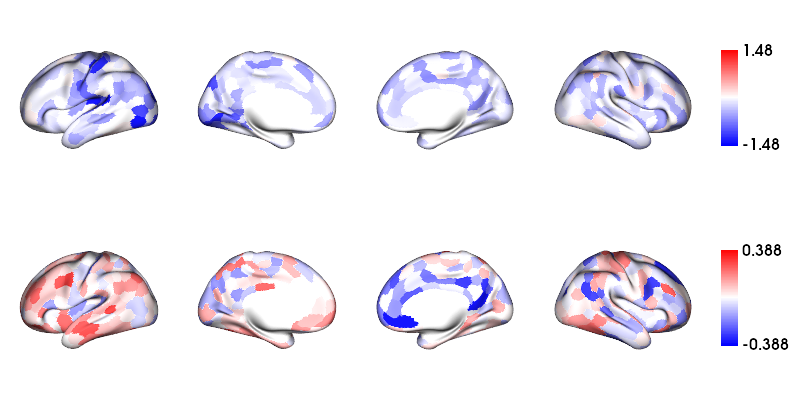

In [228]:
mc = np.ones([c69_inf_lh.n_points + c69_inf_rh.n_points, len(contrastnames_epiencode)])*np.nan
for h,hemi in enumerate(hemis):
    for i in range(nP):
        for c, contrast_name in enumerate(contrastnames_epiencode): 
            mc[parc==(i+1+(h*nP))] = np.nanmean(contrasts_epiencode_neo,axis=2)[i,h,c]
plot_hemispheres( c69_inf_lh,  c69_inf_rh,array_name=np.hsplit(mc,len(contrastnames_epiencode)), 
                 size=(800,200*len(contrastnames_epiencode)), color_bar=True, cmap='bwr', embed_nb=True,nan_color=(1, 1, 1, 1))

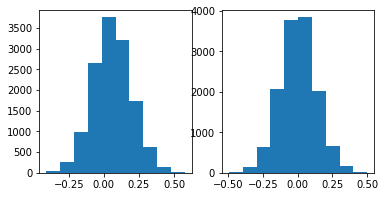

In [116]:
mfcorr = []
sdfcorr = []
corr = np.zeros((len(subs)*2,len(subs)*2,len(contrastnames_epiencode)))
fig, ax = plt.subplots(nrows=1, ncols=len(contrastnames_epiencode), figsize=(3*len(contrastnames_epiencode),3))
for f,feature in enumerate(contrastnames_epiencode):
    cdat = contrasts_epiencode_neo[:,:,:,f].reshape((nP,-1))
    corr[:,:,f] = np.corrcoef(cdat.T)
    fcorr = corr[:,:,f][np.triu_indices(len(subs)*2,k=1)]
    ax[f].hist(fcorr)
    mfcorr.append(np.nanmean(fcorr))
    sdfcorr.append(np.nanstd(fcorr))

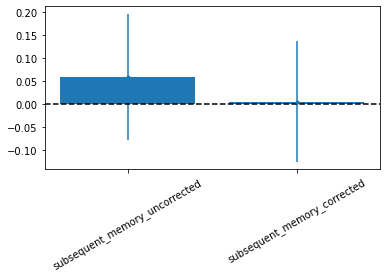

In [117]:
xnames = contrastnames_epiencode

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(3*len(contrastnames_epiencode),3))
plt.bar(range(len(contrastnames_epiencode)),mfcorr)
plt.errorbar(range(len(contrastnames_epiencode)),mfcorr, yerr=sdfcorr, fmt=".")
plt.xticks(ticks=range(len(contrastnames_epiencode)),labels=xnames,rotation=30);
plt.axhline(y=0, color='k', linestyle='--')
#plt.ylim([0,.9]);